## Decisões finais de limpeza e transformação – Silver Layer

- **`product_id`**
  - garantir ausência de valores nulos. Em caso de nulo, eliminar a linha por se tratar de chave primária (necessária para joins). contar e registar o número de ocorrências.
  - garantir unicidade. Em caso de duplicado, manter a última ocorrência (pressupondo que é a mais recente e consistente). contar e registar as ocorrências eliminadas.

- **`product_length`** , **`product_depth`** , **`product_width`**
  - converter explicitamente para tipo float (mesmo que já venha como tal), por prevenção de erros futuros.
  - substituir valores negativos e = 0 por null, preservando os restantes atributos da linha.
  - manter valores nulos (NaN), pois o tratamento dependerá do contexto analítico do consumidor.

- **`cluster_id`**
  - converter todos os valores para minúsculas para garantir consistência.
  - substituir valores nulos por "unknown", mantendo o tipo como object.
  - aplicar .strip() para remover espaços ou caracteres indesejados.

- **`hierarchy1_id` a `hierarchy5_id`**
  - garantir tipo object e aplicar .strip() e .lower() para padronização textual.
  - validar coerência entre níveis hierárquicos: cada nível inferior deve estar associado a apenas um nível superior. contar e registar qualquer incoerência identificada através de groupby().nunique().


## Insigts EDA

- Unicidade na PK (product_id) OK , sem duplicados
- Missing Values:
    - product lenght : 3%
    - product depth : 2%
    - product width: 2%
    - cluster_id : 7% (será subsituido por unknown para ter valor categórico associada)
    - hierarchy's : 0
- Invalid Values:
    - não há valores negativos em product lenght, depth, width
    - há valores = 0 em product lenght, depth, width - erro de entrada (serão substituidos por null)
- Outliers:
    - product_lengt, depth e width com outliers 10x superiores à média e mediana
- Estatística:
    - cluster_1 tem 64% de frequência (bem mais comum que os restantes)
    - hierarchy1_id = H02 tem apenas 1.2% de frequência (muito pouca representação)
    - restantes hierarquias com frequência ok
    - Hierarquias:
        - H1 : 4 grupos
        - H2 : 18 grupos
        - H3 : 79 grupos
        - H4 : 168 grupos
        - H5 : 373 grupos

# SILVER EDA PRODUCTS TABLE 
## Objetivo: Definir Regras de Limpeza e Transformação dos dados

In [1]:
# Librarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

StatementMeta(, dcd20c10-e60d-446a-83c7-1eeb54f2b083, 19, Finished, Available, Finished)

In [ ]:
df_products = spark.sql("SELECT * FROM Raw_data.product.raw_data")


df_products = df_products.toPandas()

StatementMeta(, dcd20c10-e60d-446a-83c7-1eeb54f2b083, 20, Finished, Available, Finished)

In [3]:
# 2. Visão geral dos dados
print("\n--- Dimensão do DataFrame ---")
print(df_products.shape)

print("\n--- Primeiras linhas ---")
print(df_products.head())

print("\n--- Tipos de dados ---")
print(df_products.dtypes)

print("\n--- Presença de valores nulos por coluna ---")
print(df_products.isnull().sum())

StatementMeta(, dcd20c10-e60d-446a-83c7-1eeb54f2b083, 21, Finished, Available, Finished)


--- Dimensão do DataFrame ---
(699, 10)

--- Primeiras linhas ---
  product_id product_length product_depth product_width cluster_id  \
0      P0000            5.0          20.0          12.0       None   
1      P0001           13.5          22.0          20.0  cluster_5   
2      P0002           22.0          40.0          22.0  cluster_0   
3      P0004            2.0          13.0           4.0  cluster_3   
4      P0005           16.0          30.0          16.0  cluster_9   

  hierarchy1_id hierarchy2_id hierarchy3_id hierarchy4_id hierarchy5_id  
0           H00         H0004       H000401     H00040105   H0004010534  
1           H01         H0105       H010501     H01050100   H0105010006  
2           H03         H0315       H031508     H03150800   H0315080028  
3           H03         H0314       H031405     H03140500   H0314050003  
4           H03         H0312       H031211     H03121109   H0312110917  

--- Tipos de dados ---
product_id        object
product_length    o

###

## Análise por Coluna

In [ ]:
# Product_id (Primary key)
print("Product_id")
print("Tipo:", df_products['product_id'].dtype)
print("Nulos:", df_products["product_id"].isnull().sum())
print("Duplicados:", df_products.duplicated(subset=["product_id"]).sum())
print("Valores únicos:", df_products["product_id"].nunique())

StatementMeta(, dcd20c10-e60d-446a-83c7-1eeb54f2b083, 22, Finished, Available, Finished)

Product_id
Tipo: object
Nulos: 0
Duplicados: 0
Valores únicos: 699


StatementMeta(, dcd20c10-e60d-446a-83c7-1eeb54f2b083, 23, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


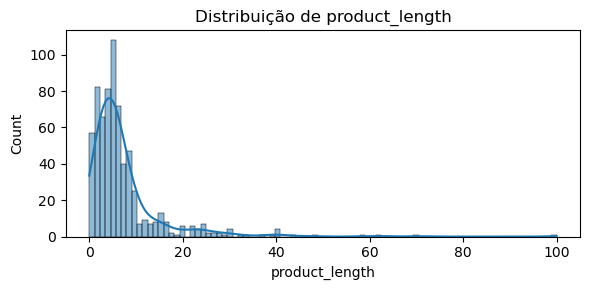

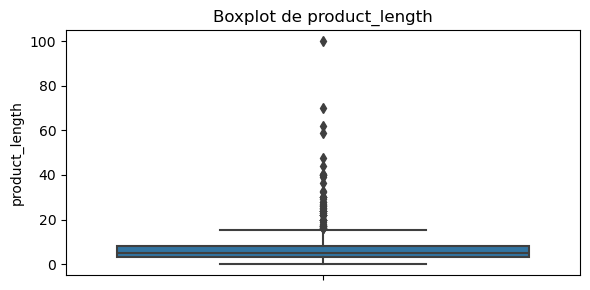

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


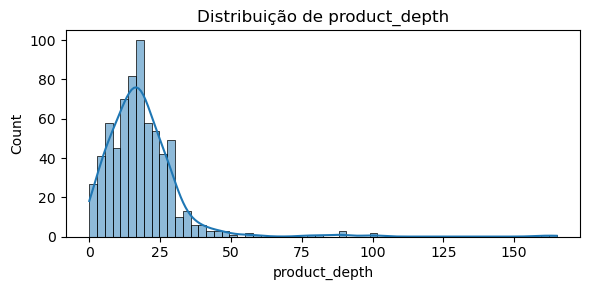

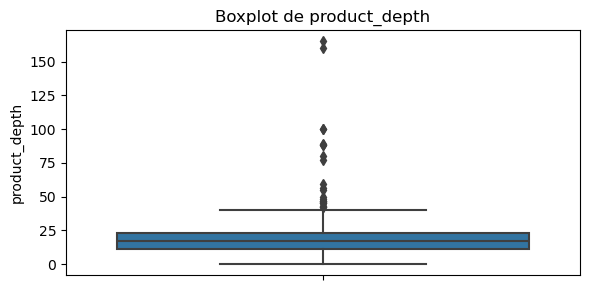

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


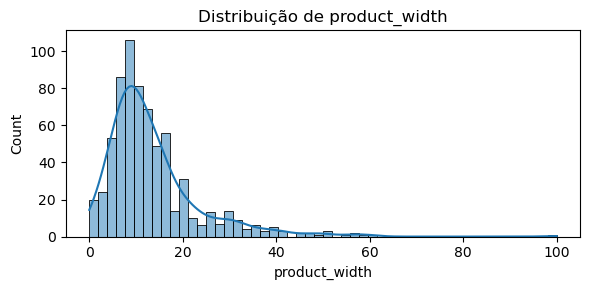

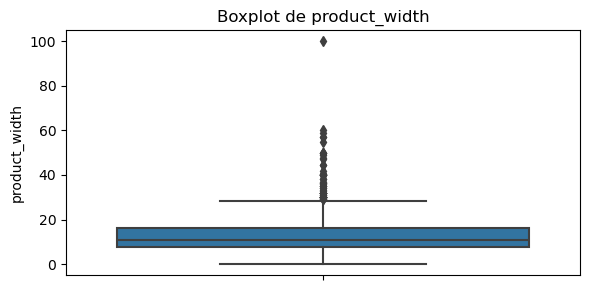

In [17]:
# Colunas Numéricas
num_cols = ["product_length", "product_depth", "product_width"]

for col_name in num_cols:
    # 1) converter para numérico
    df_products[col_name] = pd.to_numeric(df_products[col_name], errors='coerce')

    print(f"{col_name}")
    print("Tipo:", df_products[col_name].dtype)
    print("Nulos:", df_products[col_name].isnull().sum())
    print("Valores negativos:", (df_products[col_name] < 0).sum())
    print(df_products[col_name].describe())

    # Distribuição dos valores
    plt.figure(figsize=(6, 3))
    sns.histplot(df_products[col_name], kde=True)
    plt.title(f"Distribuição de {col_name}")
    plt.tight_layout()
    plt.show()

    # Outliers (vertical boxplot)
    plt.figure(figsize=(6, 3))
    sns.boxplot(y=df_products[col_name])          # <— valor em y
    plt.title(f"Boxplot de {col_name}")
    plt.tight_layout()
    plt.show()

StatementMeta(, dcd20c10-e60d-446a-83c7-1eeb54f2b083, 24, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


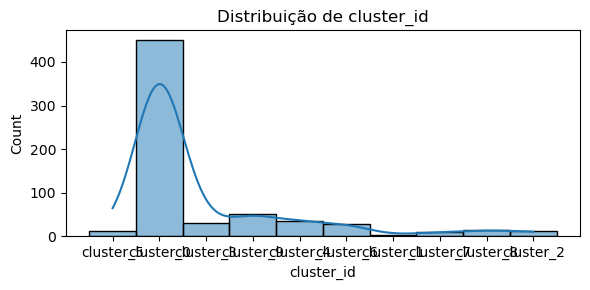

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


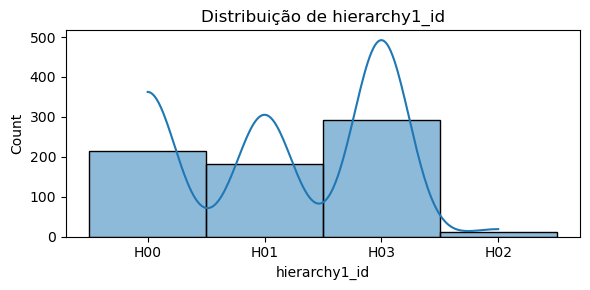

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


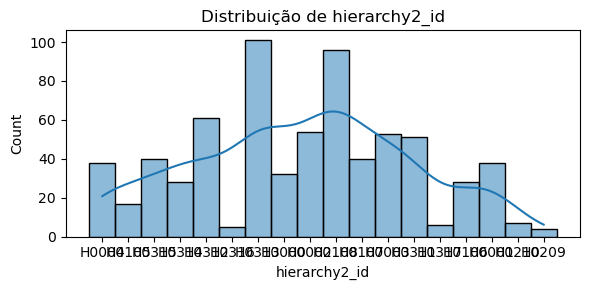

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


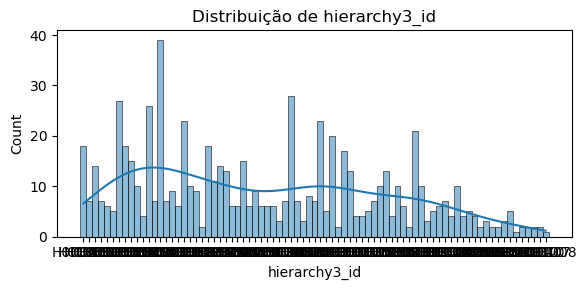

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


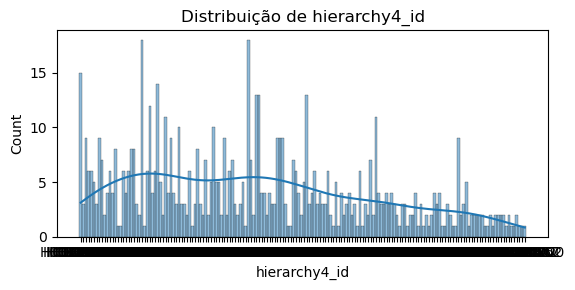

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


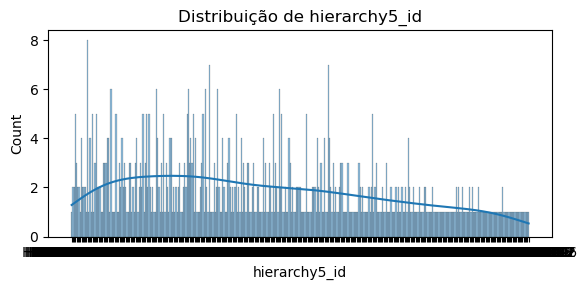

In [23]:
# Colunas categóricas
cat_cols = ["cluster_id", "hierarchy1_id", "hierarchy2_id", "hierarchy3_id", "hierarchy4_id", "hierarchy5_id"]
for col_name in cat_cols:
    print(f"{col_name}")
    print("Tipo:", df_products[col_name].dtype)
    print("Nulos:", df_products[col_name].isnull().sum())
    print("Valores únicos:", df_products[col_name].nunique())
    print("Frequência:")
    print(df_products[col_name].value_counts(dropna=False).head(10))
    # Frequência %
    cat_cols_freq_percent = df_products[col_name].value_counts(normalize=True, dropna=False).head(10) * 100
    print("\nFrequência %:")
    print(cat_cols_freq_percent.round(2))
    # Distribuição Visual dos valores
    plt.figure(figsize=(6, 3))
    sns.histplot(df_products[col_name], kde=True)
    plt.title(f"Distribuição de {col_name}")
    plt.tight_layout()
    plt.show()



## Validação hierarquica das categorias
Verificar se as categorias estão bem associadas aos níveis inferiores


StatementMeta(, dcd20c10-e60d-446a-83c7-1eeb54f2b083, 25, Finished, Available, Finished)

Nº de incoerências: 0
   hierarchy1_id hierarchy2_id  count
2            H00         H0002     54
3            H00         H0003     53
1            H00         H0001     38
4            H00         H0004     38
0            H00         H0000     32
8            H01         H0108     96
7            H01         H0107     40
6            H01         H0106     28
5            H01         H0105     17
10           H02         H0210      7
9            H02         H0209      4
13           H03         H0313    101
12           H03         H0312     61
11           H03         H0311     51
15           H03         H0315     40
14           H03         H0314     28
17           H03         H0317      6
16           H03         H0316      5


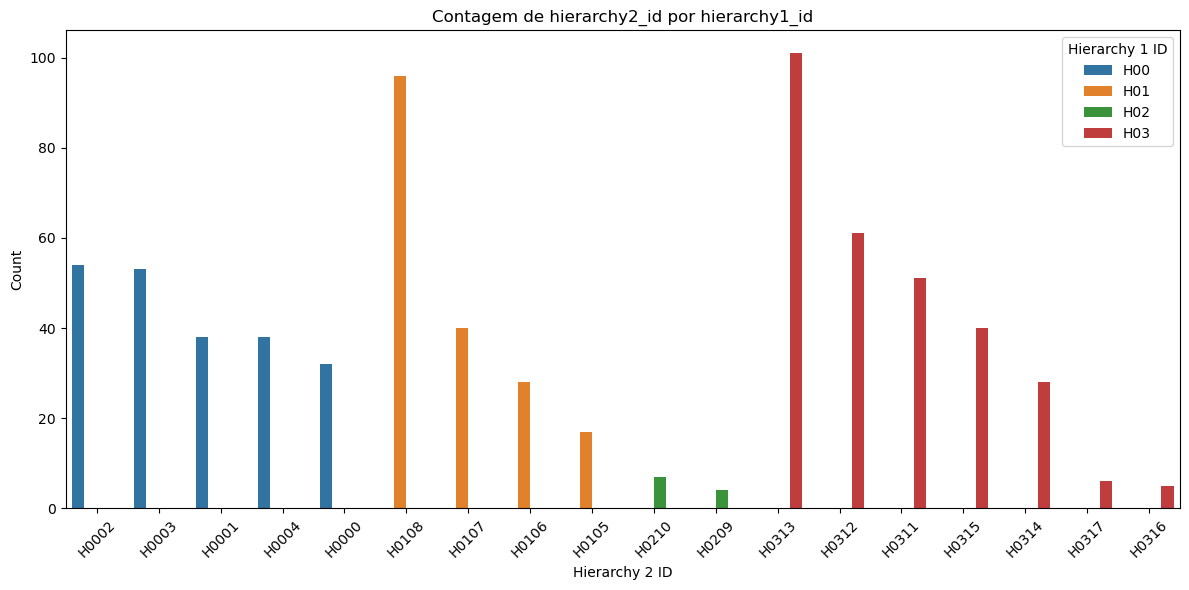

In [39]:
print("Nº de incoerências:", (df_products.groupby("hierarchy2_id")["hierarchy1_id"].nunique() > 1).sum()) # Verifica se cada hierarchy2_id está ligado apenas a um único hierarchy1_id

# Contagem entre hierarchy1_id e hierarchy2_id, agrupado por pares únicos
count_h1_h2 = (
    df_products
    .groupby(["hierarchy1_id", "hierarchy2_id"])
    .size()
    .reset_index(name="count")
    .sort_values(["hierarchy1_id", "count"], ascending=[True, False])
)

print(count_h1_h2)

# Gráfico distribuição da hierarchy2_id por hierarchy1_id
plt.figure(figsize=(12, 6))
sns.barplot(data=count_h1_h2, x="hierarchy2_id", y="count", hue="hierarchy1_id")
plt.title("Contagem de hierarchy2_id por hierarchy1_id")
plt.xlabel("Hierarchy 2 ID")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Hierarchy 1 ID")
plt.tight_layout()
plt.show()

In [40]:
print("Nº de incoerências:", (df_products.groupby("hierarchy3_id")["hierarchy2_id"].nunique() > 1).sum())


# Contagem entre hierarchy2_id e hierarchy3_id, agrupado por pares únicos
val_h2_h3 = (
    df_products
    .groupby(["hierarchy2_id", "hierarchy3_id"])
    .size()
    .reset_index(name="count")
    .sort_values(["hierarchy2_id", "count"], ascending=[True, False])
)

val_h2_h3

StatementMeta(, dcd20c10-e60d-446a-83c7-1eeb54f2b083, 26, Finished, Available, Finished)

Nº de incoerências: 0


,hierarchy2_id,hierarchy3_id,count
1,H0000,H000004,18
0,H0000,H000003,7
2,H0000,H000005,7
5,H0001,H000102,13
7,H0001,H000105,13
...,...,...,...
72,H0315,H031502,6
74,H0315,H031506,4
76,H0315,H031512,2
77,H0316,H031608,5


In [41]:
print("Nº de incoerências:", (df_products.groupby("hierarchy4_id")["hierarchy3_id"].nunique() > 1).sum())

# Contagem entre hierarchy3_id e hierarchy4_id, agrupado por pares únicos
val_h3_h4 = (
    df_products
    .groupby(["hierarchy3_id", "hierarchy4_id"])
    .size()
    .reset_index(name="count")
    .sort_values(["hierarchy3_id", "count"], ascending=[True, False])
)

val_h3_h4

StatementMeta(, dcd20c10-e60d-446a-83c7-1eeb54f2b083, 27, Finished, Available, Finished)

Nº de incoerências: 0


,hierarchy3_id,hierarchy4_id,count
0,H000003,H00000300,5
1,H000003,H00000309,1
2,H000003,H00000310,1
3,H000004,H00000400,9
4,H000004,H00000405,9
...,...,...,...
163,H031508,H03150809,5
164,H031512,H03151215,2
165,H031608,H03160817,5
166,H031702,H03170212,4


In [42]:
print("Nº de incoerências:", (df_products.groupby("hierarchy5_id")["hierarchy4_id"].nunique() > 1).sum())


# Contagem entre hierarchy4_id e hierarchy5_id, agrupado por pares únicos
val_h4_h5 = (
    df_products
    .groupby(["hierarchy4_id", "hierarchy5_id"])
    .size()
    .reset_index(name="count")
    .sort_values(["hierarchy4_id", "count"], ascending=[True, False])
)

val_h4_h5

StatementMeta(, dcd20c10-e60d-446a-83c7-1eeb54f2b083, 28, Finished, Available, Finished)

Nº de incoerências: 0


,hierarchy4_id,hierarchy5_id,count
0,H00000300,H0000030001,5
1,H00000309,H0000030901,1
2,H00000310,H0000031001,1
3,H00000400,H0000040001,5
4,H00000400,H0000040012,3
...,...,...,...
370,H03170212,H0317021212,2
368,H03170212,H0317021202,1
369,H03170212,H0317021204,1
371,H03170215,H0317021508,1


In [ ]:
print("Grupos por Hierarquia:")
print("hierarchy1_id:", count_h1_h2["hierarchy1_id"].nunique())
print("hierarchy2_id:", count_h1_h2["hierarchy2_id"].nunique())
print("hierarchy3_id:", val_h2_h3["hierarchy3_id"].nunique())
print("hierarchy4_id:", val_h3_h4["hierarchy4_id"].nunique())
print("hierarchy5_id:", val_h4_h5["hierarchy5_id"].nunique())

StatementMeta(, dcd20c10-e60d-446a-83c7-1eeb54f2b083, 29, Finished, Available, Finished)

Grupos por Hierarquia:
hierarchy1_id: 4
hierarchy2_id: 18
hierarchy3_id: 79
hierarchy4_id: 168
hierarchy5_id: 373


 Há coerência entre todas as hierarquias visto que temos hierarchy_ids inferiores ligados a apenas 1 hierarchy_id superior. Observamos também uma sequência numérica lógica de uma hierarquia para outra à medida que as hierarquias vão crescendo de valor numérico.


## Analyze Products with Null size

In [ ]:
from pyspark.sql import functions as F

# 1) Carregue SÓ no Spark
df_products_spark = spark.sql("SELECT * FROM Raw_data.product.raw_data")
df_sales_spark    = spark.sql("SELECT * FROM Raw_data.sales.raw_data")

# 2) Filtrar no Spark: produtos com qualquer dimensão NULL
products_null = df_products_spark.filter(
    (F.col("product_length").isNull()) |
    (F.col("product_depth" ).isNull()) |
    (F.col("product_width" ).isNull())
)

# 3) Fazer o join (left) para trazer vendas, mesmo que não haja registro
joined = products_null.join(
    df_sales_spark,
    on="product_id",
    how="left"
)

# 4) Agrupar por product_id + dimensões e agregar vendas
result = (
    joined
    .groupBy(
        "product_id",
        "product_length",
        "product_depth",
        "product_width"
    )
    .agg(
        F.count("sales").alias("num_sales_records"),
        F.sum  ("sales").alias("total_units_sold")
    )
    .withColumn(
        "has_sales",
        F.when(F.col("total_units_sold") > 0, True).otherwise(False)
    )
)

# 5) Mostrar
result.show(truncate=False)

StatementMeta(, dcd20c10-e60d-446a-83c7-1eeb54f2b083, 34, Finished, Available, Finished)

+----------+--------------+-------------+-------------+-----------------+------------------+---------+
|product_id|product_length|product_depth|product_width|num_sales_records|total_units_sold  |has_sales|
+----------+--------------+-------------+-------------+-----------------+------------------+---------+
|P0155     |NULL          |NULL         |NULL         |311              |18.529999999999998|true     |
|P0176     |NULL          |NULL         |NULL         |789              |269.814           |true     |
|P0214     |NULL          |NULL         |NULL         |2558             |588.0             |true     |
|P0727     |NULL          |NULL         |NULL         |0                |NULL              |false    |
|P0031     |NULL          |NULL         |NULL         |546              |39.248000000000005|true     |
|P0062     |NULL          |NULL         |NULL         |20112            |1663.0            |true     |
|P0298     |NULL          |NULL         |NULL         |0                |

In [ ]:
# Filtra apenas as vendas do produto P0155
sales_P0155 = df_sales_spark.filter(
    F.col("product_id") == "P0155"
)

# Exibe todos os campos (sem truncar valores longos)
sales_P0155.show(truncate=False)

StatementMeta(, dcd20c10-e60d-446a-83c7-1eeb54f2b083, 35, Finished, Available, Finished)

+-------+--------+----------+----------+-----+-------+-----+-----+------------+-----------+------------+-----------+----------------+---------------------+
|_c0    |store_id|product_id|date      |sales|revenue|stock|price|promo_type_1|promo_bin_1|promo_type_2|promo_bin_2|promo_discount_2|promo_discount_type_2|
+-------+--------+----------+----------+-----+-------+-----+-----+------------+-----------+------------+-----------+----------------+---------------------+
|3574684|S0056   |P0155     |2019-06-03|1.918|53.1   |0    |NA   |PR14        |NA         |PR03        |NA         |NA              |NA                   |
|3591215|S0056   |P0155     |2019-08-01|0    |0      |16   |32.9 |PR14        |NA         |PR03        |NA         |NA              |NA                   |
|3591495|S0056   |P0155     |2019-08-02|0    |0      |16   |32.9 |PR14        |NA         |PR03        |NA         |NA              |NA                   |
|3591779|S0056   |P0155     |2019-08-03|0    |0      |16   |32.9

## Decisões finais de limpeza e transformação – Silver Layer

- **`product_id`**
  - garantir ausência de valores nulos. Em caso de nulo, eliminar a linha por se tratar de chave primária (necessária para joins). contar e registar o número de ocorrências.
  - garantir unicidade. Em caso de duplicado, manter a última ocorrência (pressupondo que é a mais recente e consistente). contar e registar as ocorrências eliminadas.

- **`product_length`** , **`product_depth`** , **`product_width`**
  - converter explicitamente para tipo float (mesmo que já venha como tal), por prevenção de erros futuros.
  - substituir valores negativos e = 0 por null, preservando os restantes atributos da linha.
  - manter valores nulos (NaN), pois o tratamento dependerá do contexto analítico do consumidor.

- **`cluster_id`**
  - converter todos os valores para minúsculas para garantir consistência.
  - substituir valores nulos por "unknown", mantendo o tipo como object.
  - aplicar .strip() para remover espaços ou caracteres indesejados.

- **`hierarchy1_id` a `hierarchy5_id`**
  - garantir tipo object e aplicar .strip() e .lower() para padronização textual.
  - validar coerência entre níveis hierárquicos: cada nível inferior deve estar associado a apenas um nível superior. contar e registar qualquer incoerência identificada através de groupby().nunique().



## Insigts EDA

- Unicidade na PK (product_id) OK , sem duplicados
- Missing Values:
    - product lenght : 3%
    - product depth : 2%
    - product width: 2%
    - cluster_id : 7% (será subsituido por unknown para ter valor categórico associada)
    - hierarchy's : 0
- Invalid Values:
    - não há valores negativos em product lenght, depth, width
    - há valores = 0 em product lenght, depth, width - erro de entrada (serão substituidos por null)
- Outliers:
    - product_lengt, depth e width com outiliers 10x superiores à média e mediana
- Estatística:
    - cluster_1 tem 64% de frequência (bem mais comum que os restantes)
    - hierarchy1_id = H02 tem apenas 1.2% de frequência (muito pouca representação)
    - restantes hierarquias com frequência ok
    - Hierarquias:
        - H1 : 4 grupos
        - H2 : 18 grupos
        - H3 : 79 grupos
        - H4 : 168 grupos
        - H5 : 373 grupos